**050-jags2pymc3**

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt

# The  Models of Chapter 8 in PyMC3

When reading this chapter please study, and understand the PyMC3 models corresponding to the JAGS models in the book.  You do not need to learn how JAGS is used, unles you are interested.  We do not use it in the course.

The section numbers before refer to section numbers in the book.  We strive to maintain the same variable names as in the JAGS models to make the correspondance clear.

This self study notebook replaces both the lecture and the exercises this week. It should be read along with the book.

## 8.2.1 Load data

In [2]:
myData = pd.read_csv('z15N50.csv') # the dataset from the book's bundle
Ntotal = len (myData)

Interestingly the file (obtained from the book website) has z / N ~ 0.3, whereas the text of the chapter suggests around 0.75.  For this reason our calculations and graphs will be different than those that appear in the book.
## 8.2.2 Specify model

model {

for ( i in 1:Ntotal ) {

y[i]  ̃ dbern( theta )   # likelihood

}

theta  ̃ dbeta( 1 , 1 )  # prior

}

In [3]:
with pm.Model() as model1:
    theta = pm.Beta(name="theta",  alpha=1, beta=1) # testval=
    y = [ pm.Bernoulli(name = f"y{i}", p=theta, observed=myData.y[i]) 
             for i, y in enumerate(myData.y)]

* Note that above we plugin the observed data, once per coin, much earlier than in the JAGs model.

## 8.2.3 Initialize chains

Followig the book we want to start our chains at the maximum likelihood estimate value (MLE). MLE (the mode of the likelihood function) is a useful term to remember.  This is the weakest form of prediction we can often do, but apparently serves as a good initializer.

In [4]:
thetaInit = { "theta": sum(myData.y) / len(myData.y) }  # z/N 
# TODO why make it a dict? since sample start parameter takes dict, or array of dict

* The book suggests to start all chainns from slightly different points.  Idea is to resample from the input data to create new samples. They will have roughly the same distribution as the input data, but the ratio of sucesses will fluctuate slightly.
* We shift the intial value from zero and one, to avoid initial value of probability zero in the prior (see Sect. 8.2.2 from where this trick comes)

In [5]:
def seed (sample):
    return sum( np.random.choice(sample, len(sample)) ) / Ntotal

initsList = [ { "theta": 0.001 + 0.998*seed(myData.y) } for _ in range(0,3) ] # 3 chains

## 8.2.4 Generate chains

* We have already created a model above and we do not need to 'send it to JAGS' so the first listning does not really have a counterpart.
* However some of the parameters are given to the sample function in PymC3
* We are allowing PyMC3 to pick up a sampler.  Since a pure Gibbs Sampler is not implmented, it will choose something else (also NUTS generalizes Gibbs in some ways).

In [6]:
with model1:
    trace = pm.sample(
        3334,  # like in JAGS this is the number of samples per chain, not the total number of samples, it also excludes the tune samples by default 
        chains=3, 
        start=initsList,
        tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [theta]
Sampling 3 chains, 0 divergences: 100%|██████████| 11502/11502 [00:06<00:00, 1816.62draws/s]


* The above already specifies the burn-in period ('tune=500') and runs the sample for collecting the data
* PyMC3 records values of all tuned parameters by default (unlike JAGs which needs to be instructed what to record)

## 8.2.5 Examine chains

/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


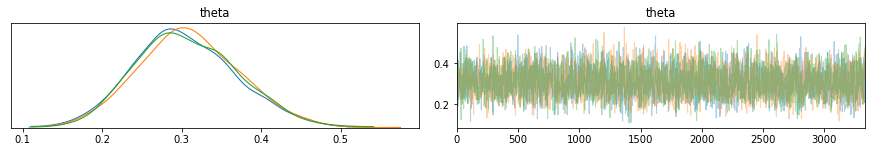

In [7]:
ax = pm.traceplot(trace, var_names=["theta"])
plt.show()

* The left plot above is the same as the bottom-right plot in Fig. 8.3 in the textbook, excep that the MCSE is reported below (in the arviz summary)
* The right plot above is the same as the top-left plot in Fig. 8.3
* We do not have any plots for the shrink factor.  The effecitve sample size (EFF) is reported below in the summary.  The Gelman-Rubin statistics (shrink factor) is replaced by R-hat in the summary below (it shuld be close to 1).
* Note that the efficiency of sampling is lower than reported in the book (where it is maximum possible).  This is probably due to differences between PyMC3 and JAGs in what models work well. Note that the above model with 50 Bernoulli coins, is very unlike our previous models.  It is interpreted by PyMC3 as 50 experiments with different bias values, drawn from the same prior.  It seems that JAGs interprets this model differently.  This is what we do below again to help you to compare. See model2.

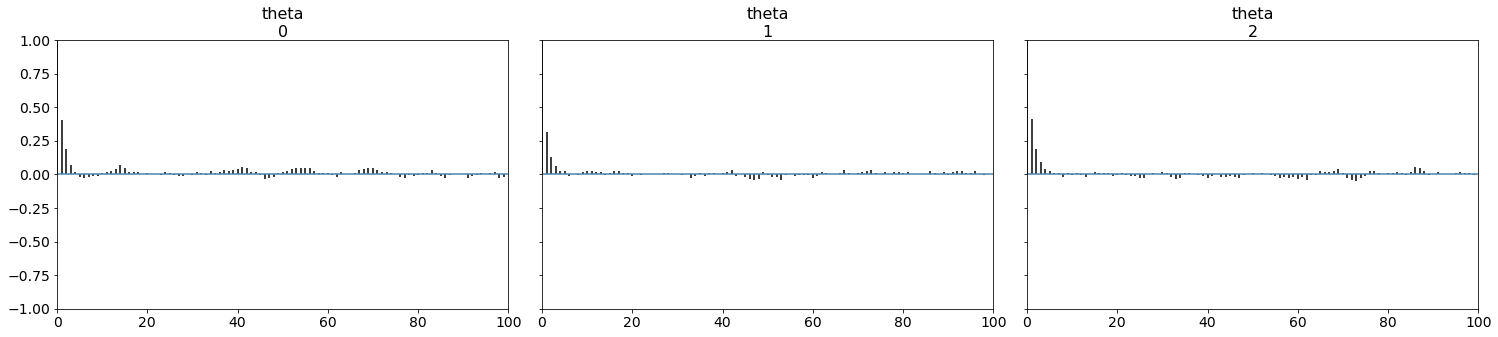

In [8]:
pm.autocorrplot(trace, var_names=["theta"])
plt.show()

In [9]:
az.summary (trace, var_names=["theta"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta  0.307  0.064    0.19    0.428      0.001    0.001    4306.0  4306.0   

       ess_bulk  ess_tail  r_hat  
theta    4267.0    6364.0    1.0

* It appears that ess_bulk is the total effective sample size (quite a bit smaller than in the book) # TODO
ess_mean is in total ess. In the book 10002 but here 4426
* There is a direct ESS computation function in arviz (Calculate estimate of the effective sample size) that seems to produce the same number as 'ess_bulk' above.  It makes sense, if we interpret 'bulk' as 'out of the entire sample size, combined for each chain'.  
* The other ess numbers above remain cryptic.

In [10]:
az.ess(trace, var_names=["theta"]).theta

<xarray.DataArray 'theta' ()>
array(4267.22918277)

### 8.2.5.1 Plotting the posterior

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89b052b5b0>],
      dtype=object)

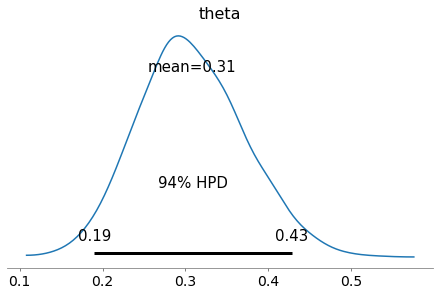

In [11]:
pm.plots.plot_posterior(trace, var_names=["theta"])

## An alternative, more natural, less dimensional model with PyMC3
* We create another model, just with a single likelihood and the prior, and we feed all observations to the single Bernoulli distribution (unlike in model1, and unlike in the book).  I suspect that this is actually the book means, but the JAGS syntax is confusing.
* This model has much less dimensions (just a single parameter), but ess_bulk is still only about half of all the samples.
* Interestingly, the ESS drops, if we allow PyMC3 to initialize the chains automatically.  So the method with resampling presented in the book does seem to improve things a bit.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [theta]
Sampling 3 chains, 0 divergences: 100%|██████████| 11502/11502 [00:06<00:00, 1800.72draws/s]
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


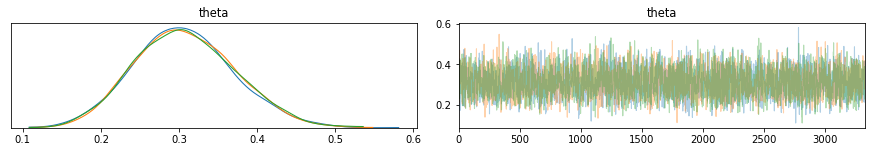

In [12]:
with pm.Model() as model2:
    theta = pm.Beta(name="theta",  alpha=1, beta=1)
    y = pm.Bernoulli(name = "y", p=theta, observed=myData.y) # TODO Does it improve efficiency. As book will states in 9.4. SPEEDING UP JAGS
    # Here you use Bernoulli in both model not binomial. It does not improve efficiency. pymc is diffrent from jarg.
    # even if you used y = [ pm.Bernoulli(name = f"y{i}", p=theta, observed=myData.y[i]) 
    #                                   for i, y in enumerate(myData.y)]
    # pymc3 will change it to 
    # y = pm.Bernoulli(name = "y", p=theta, observed=myData.y) 
   
    trace = pm.sample(
        3334,  # like in JAGS this is the number of samples per chain, not the total number of samples, it also excludes the tune samples by default 
        chains=3, 
#         start=initsList, # TODO The ESS does not drop if I allow PyMC3 to initialize the chains automatically!
# They were wrong. If you allow PyMC3 to initialize the chains automatically it will improve (increase) ESS
# As you can see. (remember to restart kernel). Well it turns out it is not allways the case!!!!
        tune=500)

ax = pm.traceplot(trace, var_names=["theta"])
plt.show()

In [13]:
az.summary (trace, var_names=["theta"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta  0.308  0.063    0.19    0.427      0.001    0.001    4288.0  4288.0   

       ess_bulk  ess_tail  r_hat  
theta    4275.0    6298.0    1.0

* Let's replicated the left plot in Figure 8.4 in the book

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89b40d94f0>],
      dtype=object)

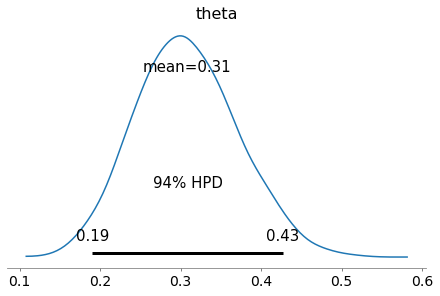

In [14]:
pm.plots.plot_posterior(trace, var_names=["theta"], point_estimate='mean')

* The default posterior plot uses a KDE (kernel density plot) not a histogram in PyMC3. Feel free to tweaek the options to obtain a histogram like in the book.  (kind='hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89b4927250>],
      dtype=object)

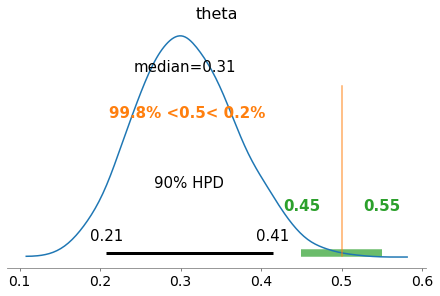

In [15]:
pm.plots.plot_posterior(trace, var_names=["theta"], point_estimate='median', ref_val=0.5, 
                        rope=(0.45,0.55), credible_interval=0.9)
# TODO rope. If rope is in the HPD interval you cannot say that the coin is biase. but here is not then 
# the coin is bias. To khow how to choose rope interval you have to wait until the Chapter 12
# https://docs.pymc.io/api/plots.html?highlight=plots%20plot_posterior#pymc3.plots.plot_posterior

* Interestingly the book remarks, that the mode is much unstable with MCMC approximations (even if most useful). Mean and median are more stable.
* Feel free to ignore ROPE (region of practical equivalence, green) for now, if the book makes sense for you.  This is properly defined and discussed in Chapter 12, which we will read later.

## 8.3  Simplified scripts for frequently used analyses
* This section is not relevant for us in the course (you can skip it)

## 8.4 Example: Difference of biases


In [16]:
myData = pd.read_csv('z6N8z2N7.csv') # the dataset from the book's bundle
y = myData.y
Ntotal = len (myData)
Nsubj = len (myData.s.unique())

In [17]:
r = myData[myData.s == 'Reginald']
r

y         s
0  1  Reginald
1  0  Reginald
2  1  Reginald
3  1  Reginald
4  1  Reginald
5  1  Reginald
6  1  Reginald
7  0  Reginald

In [18]:
t = myData[myData.s == 'Tony']
t

y     s
8   0  Tony
9   0  Tony
10  1  Tony
11  0  Tony
12  0  Tony
13  1  Tony
14  0  Tony

In [19]:
t.y, r.y

(8     0
 9     0
 10    1
 11    0
 12    0
 13    1
 14    0
 Name: y, dtype: int64,
 0    1
 1    0
 2    1
 3    1
 4    1
 5    1
 6    1
 7    0
 Name: y, dtype: int64)

In [20]:
with pm.Model() as model3: # we have two subjects
    theta1 = pm.Beta (name='theta1', alpha=2, beta=2)
    theta2 = pm.Beta (name='theta2', alpha=2, beta=2) # TODO Deterministic
    # You can assign theta1-theta2 to a variable but then you cannot plot it. It needs a name. use Deterministic
    # to achive it
    theta12 = pm.Deterministic ('theta1-theta2', theta1-theta2) # Observe, new PyMC3 construct, to create a derived variable
    y1 = pm.Bernoulli (name='y1', p=theta1, observed=r.y) # Reginald
    y2 = pm.Bernoulli (name='y2', p=theta2, observed=t.y) # Tony
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta2, theta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:12<00:00, 1731.78draws/s]


* Now we attempt to recreate parts of Figure 8.6

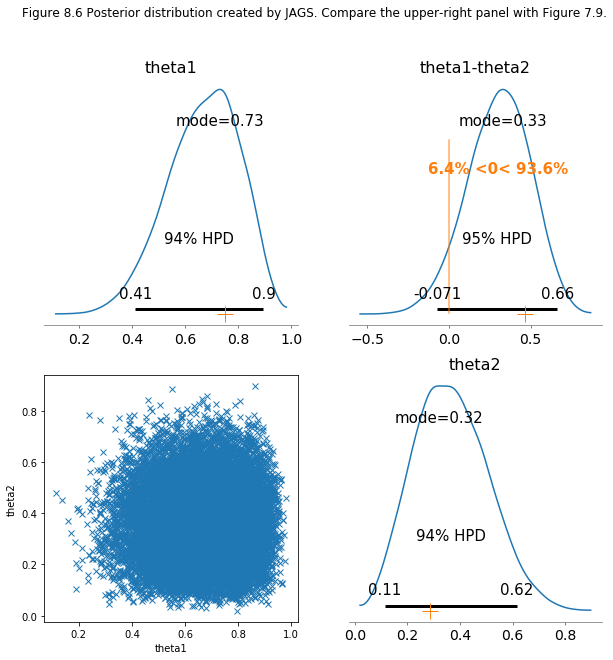

In [21]:
zN1 = sum(r.y) / len(r)
zN2 = sum(t.y) / len(t)

fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle("Figure 8.6 Posterior distribution created by JAGS. Compare the upper-right panel with Figure 7.9.")

pm.plots.plot_posterior(trace, var_names=["theta1"], ax=ax[0,0], point_estimate='mode')
# plot(x,y)
ax[0,0].plot(zN1, 0, marker='+', markersize=16, color='C1')

pm.plots.plot_posterior(trace, var_names=["theta2"], ax=ax[1,1], point_estimate='mode')
ax[1,1].plot(zN2, 0, marker='+', markersize=16, color='C1')

pm.plots.plot_posterior(trace, var_names=["theta1-theta2"], ax=ax[0,1], point_estimate='mode', 
                        credible_interval=0.95, ref_val=0)

ax[0,1].plot(zN1 - zN2, 0, marker='+', markersize=16, color='C1')

ax[1,0].plot(trace['theta1'],trace['theta2'], 'x')
ax[1,0].set_ylabel('theta2')
ax[1,0].set_xlabel('theta1')

plt.show()

## 8.5 Sampling fro the prior distribution

In [22]:
with pm.Model() as model4:
    theta1 = pm.Beta (name='theta1', alpha=2, beta=2)
    theta2 = pm.Beta (name='theta2', alpha=2, beta=2)
    theta12 = pm.Deterministic ('theta1-theta2', theta1-theta2) # Observe, new PyMC3 construct, to create a derived variable
    #y1 = pm.Bernoulli (name='y1', p=theta1)
    #y2 = pm.Bernoulli (name='y2', p=theta2)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta2, theta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:10<00:00, 1910.97draws/s]


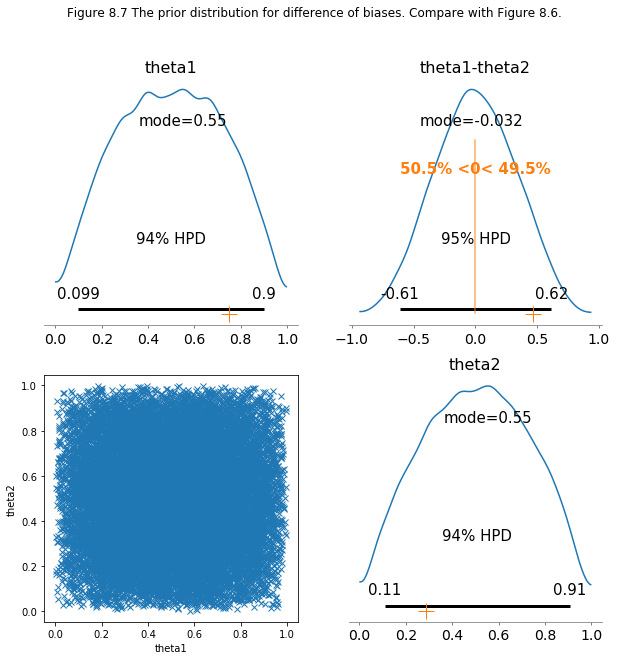

In [23]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle("Figure 8.7 The prior distribution for difference of biases. Compare with Figure 8.6.")

pm.plots.plot_posterior(trace, var_names=["theta1"], ax=ax[0,0], point_estimate='mode')
ax[0,0].plot(zN1, 0, marker='+', markersize=16, color='C1')

pm.plots.plot_posterior(trace, var_names=["theta2"], ax=ax[1,1], point_estimate='mode')
ax[1,1].plot(zN2, 0, marker='+', markersize=16, color='C1')

pm.plots.plot_posterior(trace, var_names=["theta1-theta2"], ax=ax[0,1], point_estimate='mode', 
                        credible_interval=0.95, ref_val=0)

ax[0,1].plot(zN1 - zN2, 0, marker='+', markersize=16, color='C1')

ax[1,0].plot(trace['theta1'],trace['theta2'], 'x')
ax[1,0].set_ylabel('theta2')
ax[1,0].set_xlabel('theta1')

plt.show()

## 8.6 Probability Distributions available in PyMC3

* Please see: https://docs.pymc.io/api/distributions.html

* The Bernoulli's ones and Poissons zeros tricks are not so easy to use in PyMC3.  It might be better to implement your own likelihood function. See https://docs.pymc.io/Probability_Distributions.html#custom-distributions and even https://docs.pymc.io/notebooks/blackbox_external_likelihood.html . This is not really in scope of the course, but provided here for reference, if you needed this.

## 8.9 Exercises 

Only Exercise 8.4 makes sense (and part of it is already solved above).

Bonus exercise: The teachers would be indebted for ideas how to improve ESS in Section 8.2.4-5, or for a plausible explanation why it is so much lower in our implementation than in the book.

Exercise 8.4. [Purpose: Explore the prior on a difference of parameters
implied from the priors on the individual parameters.]

(A) Reproduce Figure 8.7 in Section 8.5. Explain how you did it.

(B) Change the priors on the individual θ’s to beta(θ|1, 1) and produce the figure
anew. Describe its panels and explain.

(C) Change the priors on the individual θ’s to beta(θ|0.5, 0.5) and produce the figure
again. Describe its panels and explain.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta2, theta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:12<00:00, 1748.45draws/s]


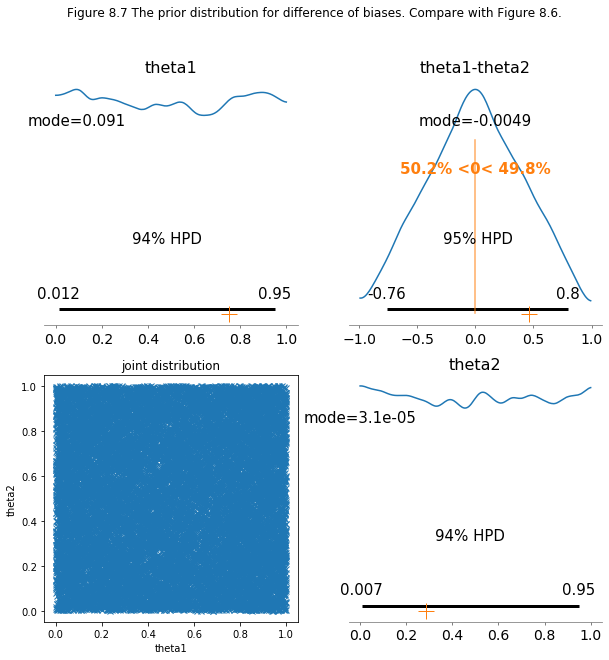

In [24]:
# (B) Change the priors on the individual θ’s to beta(θ|1, 1) and produce the figure anew. Describe its panels and explain.
with pm.Model() as modelB:
    theta1 = pm.Beta (name='theta1', alpha=1, beta=1)
    theta2 = pm.Beta (name='theta2', alpha=1, beta=1)
    theta12 = pm.Deterministic ('theta1-theta2', theta1-theta2) # Observe, new PyMC3 construct, to create a derived variable
#     It is straight forward to have pymc generate an MCMC sample from the prior: We
#     simply run the program with no data included. P.210
    #y1 = pm.Bernoulli (name='y1', p=theta1) 
    #y2 = pm.Bernoulli (name='y2', p=theta2)
    trace = pm.sample(10000)
    
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle("Figure 8.7 The prior distribution for difference of biases. Compare with Figure 8.6.")

pm.plots.plot_posterior(trace, var_names=["theta1"], ax=ax[0,0], point_estimate='mode')
ax[0,0].plot(zN1, 0, marker='+', markersize=16, color='C1')

pm.plots.plot_posterior(trace, var_names=["theta2"], ax=ax[1,1], point_estimate='mode')
ax[1,1].plot(zN2, 0, marker='+', markersize=16, color='C1')

pm.plots.plot_posterior(trace, var_names=["theta1-theta2"], ax=ax[0,1], point_estimate='mode', 
                        credible_interval=0.95, ref_val=0)

ax[0,1].plot(zN1 - zN2, 0, marker='+', markersize=16, color='C1')

ax[1,0].plot(trace['theta1'],trace['theta2'], 'x')
ax[1,0].set_ylabel('theta2')
ax[1,0].set_xlabel('theta1')
ax[1,0].set_title("joint distribution")

plt.show()

# Notice that the distributions on theta[1] and theta[2] look uniform, as they should, because that
# is a dbeta(1,1) distribution. (The modes of the distributions are spurious because they are
# merely indicating what tiny random bump in the MCMC sample happens to highest.)
# Interestingly, the prior distribution on theta[1]-theta[2] is not uniform, but is instead triangular.
# This makes sense if you consider the lower left panel, which shows the uniform distribution on
# theta[1] x theta[2] space. If you collapse that square space along the theta[1]=theta[2]
# diagonal, you see that there are a lot of points along the diagonal, but the number of points
# drops off linearly toward the corners. In any case, the moral is that uniform priors on theta[1]
# and theta[2] do not imply a uniform prior on the difference of parameters.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta2, theta1]
Sampling 2 chains, 24 divergences: 100%|██████████| 21000/21000 [00:13<00:00, 1569.64draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


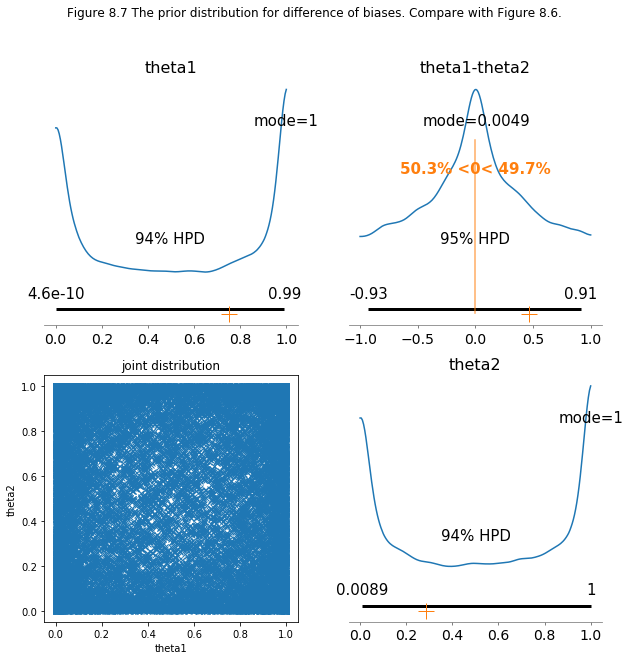

In [25]:
# (C) Change the priors on the individual θ’s to beta(θ|0.5, 0.5) and produce the figure again. Describe its panels and explain.
with pm.Model() as modelC:
    theta1 = pm.Beta (name='theta1', alpha=.5, beta=.5)
    theta2 = pm.Beta (name='theta2', alpha=.5, beta=.5)
    theta12 = pm.Deterministic ('theta1-theta2', theta1-theta2) # Observe, new PyMC3 construct, to create a derived variable
    #y1 = pm.Bernoulli (name='y1', p=theta1)
    #y2 = pm.Bernoulli (name='y2', p=theta2)
    trace = pm.sample(10000)
    
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle("Figure 8.7 The prior distribution for difference of biases. Compare with Figure 8.6.")

pm.plots.plot_posterior(trace, var_names=["theta1"], ax=ax[0,0], point_estimate='mode')
ax[0,0].plot(zN1, 0, marker='+', markersize=16, color='C1')

pm.plots.plot_posterior(trace, var_names=["theta2"], ax=ax[1,1], point_estimate='mode')
ax[1,1].plot(zN2, 0, marker='+', markersize=16, color='C1')

pm.plots.plot_posterior(trace, var_names=["theta1-theta2"], ax=ax[0,1], point_estimate='mode', 
                        credible_interval=0.95, ref_val=0)

ax[0,1].plot(zN1 - zN2, 0, marker='+', markersize=16, color='C1')

ax[1,0].plot(trace['theta1'],trace['theta2'], 'x')
ax[1,0].set_ylabel('theta2')
ax[1,0].set_xlabel('theta1')
ax[1,0].set_title("joint distribution")

plt.show()

# The individual parameters can be seen to have dbeta(0.5,0.5) marginal distributions, but the
# resulting distribution on theta[1]-theta[2] is curious. By looking at the joint distribution in the
# lower left panel, some insight can be gleaned; the joint distribution has higher density toward
# the corners. Again, the main point is that a prior on individual parameters may have unforeseen
# implications for the prior on the difference of parameters.
# When you are done with this exercise, you might want to return the program Jags-Ydich-
# XnomSsubj-MbernBeta.R to its original condition!